# Question 1 - Topics Over Time
- __(a)__ Annual Themes of Jeopardy Questions
    - Split by round: Jeopardy, Double Jeopardy, Final Jeopardy
-__(b)__ Analyze Topics over Time
    - For each year - Proportion of Questions with each theme
    - Look at __top _k_ topics__ and compare how these change year over year
        - Try to align themese from year to year, making notes on prevalence per year
-__(c)__ Analyze your findings
    - (a) How did themes change year to year
    - (b) Constant or noticeable trends
    - (c) Has Jeopardy gotten easier or harder over time?

In [1]:
# unpack data
# !tar -xzvf JEOPARDY_QUESTIONS1.json.tar.gz

In [2]:
reset -fs

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def jacc_sim(A, B):
    intersect = len(set(A).intersection(set(B)))
    unioned = len(set(A)) + len(set(B)) - intersect
    return float(unioned / interesect)

In [5]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, defaultdict

In [6]:
from sklearn.decomposition              import LatentDirichletAllocation
from sklearn.decomposition              import NMF
from sklearn.feature_extraction.text    import TfidfVectorizer
from sklearn.feature_extraction.text    import CountVectorizer
from sklearn.metrics                    import jaccard_score

In [6]:
from jeopardy_funcs import *

In [8]:
df_raw = df.copy()  # keep a copy

In [9]:
df = prep_data(df)

## Load and Prep Data

# 0. Cleanup
Some cleanup/info
- [x] air-date to datetime
- [x] encode round
    - Daily Doubles are implicit from money value - Ignore
    - 3 Tiebreakers - Drop
- [ ] value to int/standardize money,  historical info [link](https://outsider.com/news/entertainment/jeopardy-show-double-dollar-values-categories/)
    - final question's have value np.nan
    - Rank question difficulty 1 through 11 (5 qn values 1st round, 5 qn values 2nd round, 1 final jeopardy)?
    - Or 1 through 13: 5 normal qn types plus daily double per round, times 2, and 1 final jeopardy
    - ~~for the pilot, questions values were 25-125 for first round, then doubled~~ pilot not in the data
    - Jeopardy! round was 100-500 for years
    - 11/26/01 doubled all monetary values, so 200-1000 for Jeopardy! round

In [9]:
# df['air_date']= pd.to_datetime(df['air_date'])
# df['year'] = df['air_date'].dt.year

# df = df[df['round']!='Tiebreaker']

---
## Aside - Wordclouds all data

In [11]:
W, H, df, vocab, tfidf_matrix = get_topics(df, 10, ret_tfidf=True)
df.head(5)

,category,air_date,question,value,answer,round,show_number,year,topic
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",200.0,Copernicus,Jeopardy!,4680,2004,8
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,200.0,Jim Thorpe,Jeopardy!,4680,2004,3
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,200.0,Arizona,Jeopardy!,4680,2004,7
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",200.0,McDonald\'s,Jeopardy!,4680,2004,3
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",200.0,John Adams,Jeopardy!,4680,2004,8


In [12]:
# d = get_topic_word_counts(df, vocab, tfidf_matrix, verbose=True)
# This takes forever to run, while code below (running locally)
# runs in 90 secs
# this cell gets to 20k in 90 secs :(

In [31]:
# replaced with fn above
# tfidf_coo = scipy.sparse.coo_matrix(tfidf_matrix)
idx2word = {idx: word for word, idx in vocab.items()}
vf = np.vectorize((lambda x: idx2word[x]))

checkpoints = [20_000 * _ for _ in range(tfidf_matrix.shape[0])]

NameError: name 'vocab' is not defined

In [23]:
# replaced with fn above
# tfidf_coo = scipy.sparse.coo_matrix(tfidf_matrix)
start = time.time()
d = defaultdict(Counter)

checkpoints = [20_000 * _ for _ in range(tfidf_matrix.shape[0])]
topics = df.topic.values
assert len(topics), tfidf_matrix.shape[0]

for i, topic in enumerate(topics):
    _, cols = tfidf_matrix[i, :].nonzero()
    if len(cols) == 0:
        continue
    d[topic].update(set(vf(cols)))

    if i in checkpoints:
        print(f'{i:,}, {time.time() - start}')

0, 0.020754098892211914
20,000, 60.43916606903076
40,000, 121.6263689994812
60,000, 183.7149760723114
80,000, 245.9291069507599
100,000, 308.3511610031128
120,000, 373.6835548877716
140,000, 434.7229700088501
160,000, 494.29280710220337
180,000, 555.9635410308838
200,000, 616.2574660778046


__word cloud__

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [31]:
def generate_wc(word_freqs):
    '''given a dictionary of words and their counts, generate and plot a wordcloud'''
    wc = WordCloud(width=600, height=600,
               background_color='white',
               #stopwords=set(STOPWORDS),
               min_font_size=10)
    wc.generate_from_frequencies(word_freqs)
    return wc

WordClouds python package [docs](http://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud). Can save as SVG

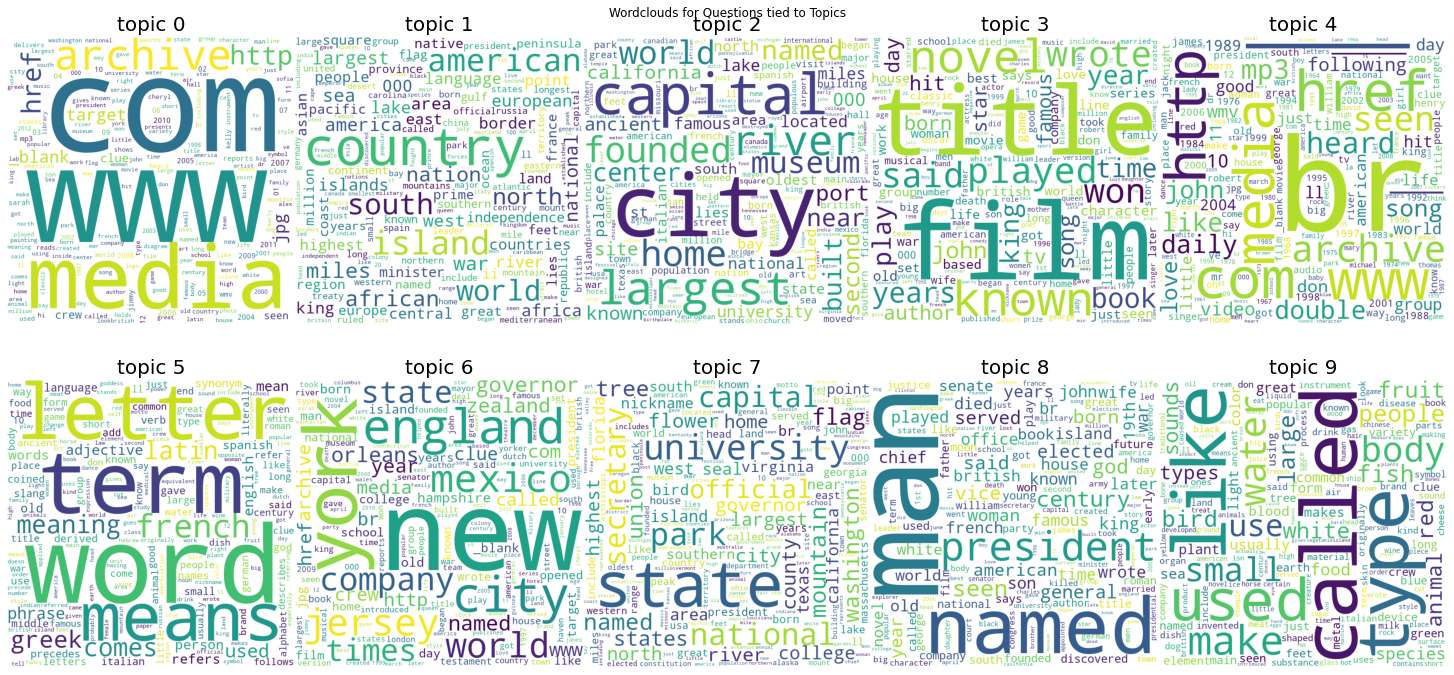

In [43]:
fig, axes = plt.subplots(2,5, figsize=(20,10), facecolor=None)

axes=axes.flatten()
for i, ax in enumerate(axes):
    wc = generate_wc(d[i])
    ax.imshow(wc)
    ax.set_title(f"topic {i}", fontsize=20)
    ax.axis("off")
    
# plt.axis("off")
plt.tight_layout(pad=0)
plt.suptitle("Wordclouds for Questions tied to Topics")
plt.show()
# plt.savefig('all_qns_wc.png')

Maybe we need to clean up the questions first so we don't get weird words like these. One way could be to increase 'max_df' for the vectorizer.

- seting `min_df=3` drops 90k total to 41k words
    - `default=1` means `min_df=3` is a $\geq$
    - still has '00' etc in it

Text(0.5, 1.0, 'Histogram of Counts Per Topic')

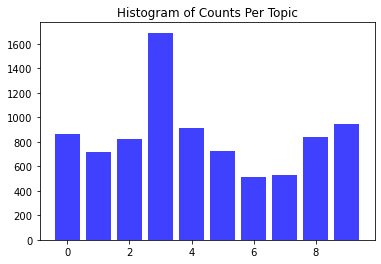

In [42]:
# for funsies - could make this a stacked histogram slowly changing color over time
plt.bar(range(W.shape[1]), np.sum(W, axis=0), alpha=.75, color='blue')
plt.title('Histogram of Counts Per Topic')

## Heatmaps All Data
Want to plot heatmap of counts per topic per year (large grid)

Have `H` and `samp` with index, go back and grab year 

In [21]:
# counts per year per topic
topic_year_cts = df.groupby(['year', 'topic'])['question'].count()

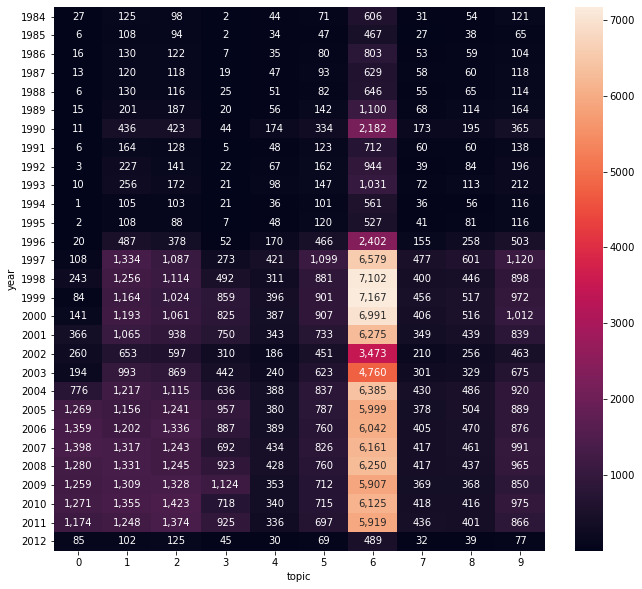

In [22]:
# z = np.array([[1,2],[3,4]])
fig, ax = plt.subplots(figsize=(11,10))
sns.heatmap(topic_year_cts.unstack(), annot=True, fmt=',');

Normalize counts by year

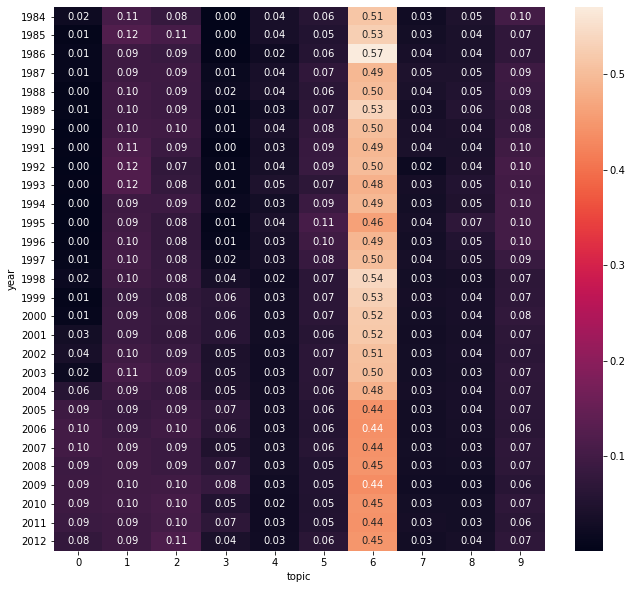

In [23]:
tpc_yr_df = topic_year_cts.unstack()
tpc_yr_normed = tpc_yr_df.div(tpc_yr_df.sum(axis=1), axis=0)

# z = np.array([[1,2],[3,4]])
fig, ax = plt.subplots(figsize=(11,10))
sns.heatmap(tpc_yr_normed, annot=True, fmt=',.2f');

# 1.A - Topics Over Time
- Compare topics over time
- get topics by year
    - start - topics

__Jeopardy Round__

In [10]:
# lets do jeopardy round first
df_jpr_rd = df[df['round']=='Jeopardy!'].copy()

In [137]:
num_topics = 25
top_topics = 5

Apply NMF with _k_ topics, and grab the top topics per year in case we need them later. Topics contain all words in the vocab ordered by their relevance to the topic - first word being most important

In [21]:
jpr_year_results = get_relevancies(df[df['round']=='Jeopardy!'], 
                                   num_topics=num_topics, 
                                   top_topics=top_topics, 
                                   col='year', 
                                   verbose=False)

/Users/krisjohnson/anaconda3/envs/nx/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


---

For each topic in a given year, give me the highest likely topic in the next year

- Jaccard Similarity to link topics over years
    - min_max scale each year to normalize Jaccard values to [0,1] range
    - issues: 
         - vocab size can vary heavily over time, so hard coding `max_elem` breaks, using percentage
         - Some years only have half their overall vocab in common, inherently dampens Jaccard scores

In [123]:
# moved to jeopardy_funcs.py
# def jacc_sim(A, B):
#     intersection = len(list(set(A).intersection(B)))
#     unioned = len(set(A)) + len(set(B)) - intersection
    
#     return float(intersection) / unioned

In [89]:
len(df['year'].unique())

29

create a numpy array of jacq_similarity between topics of current year and all topics in next year. Want to trace top topics over time. 

Jacques Similarity gets normalized, per year over all possible jacquard scores, after collecting all the scores

In [110]:
year_connects = len(df['year'].unique()) -1

jacq_scores = np.zeros(shape=(year_connects, top_topics))
jacq_connect = np.zeros(shape=(year_connects, top_topics))

In [ ]:
max_elem = .25

years = sorted(df['year'].unique())
scores = np.zeros(shape=(year_connects, num_topics, num_topics))

# iterate over in betweens, not all years
for i, year in enumerate(years[:-1]):
    print(year)
    
    this_year_topics = jpr_year_results[year]['relevant_words']
    
    # take vocab length and max_elem percentage to find max element index
    # need to do this since vocab sizes vary wildly, so hard-coded max_elem doesnt work
    this_year_max_elem = int(len(this_year_topics[0]) * max_elem)
    
    next_year_topics = jpr_year_results[year+1]['relevant_words']
    next_year_max_elem = int(len(next_year_topics[0]) * max_elem)
    
    for j, topic_a in enumerate(this_year_topics):
        for k, topic_b in enumerate(next_year_topics):
            scores[i,j,k] = jacc_sim(topic_a[:this_year_max_elem], topic_b[:next_year_max_elem])
            
#         jacq_scores[i, j] = max(scores)
#         jacq_connect[i, j] = np.argsort(scores)[-1]


In [172]:
def min_max_scale(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

scores = np.apply_along_axis(min_max_scale, axis=0, arr=scores)

In [169]:
scores.shape  # year_connections, topic_year_1, topic_year_2

(28, 25, 25)

Allow multiple topics to connect to the same next year's topic, why there are duplicate numbers in the output of the following cell:

In [191]:
np.argmax(scores[0], axis=1)#, keepdims=True)

array([23, 14,  7, 19,  7, 18, 19,  3, 23, 17, 19, 14, 12, 17,  7,  8, 20,
       13,  0,  6,  8,  2,  7, 17, 19])

In [341]:
# Argmax to get the next year topic each current year topic matches with best
# convert scores into array of points
max_scores = np.apply_along_axis(np.max, arr=scores, axis=2)

score_idx = np.apply_along_axis(np.argmax, axis=2 ,arr=scores)
score_idx.shape

(28, 25)

In [321]:
score_idx[0] # so who does everyone in year 0 (1984) link to in 1985; 0->23, 1->14, etc

array([23, 14,  7, 19,  7, 18, 19,  3, 23, 17, 19, 14, 12, 17,  7,  8, 20,
       13,  0,  6,  8,  2,  7, 17, 19])

In [331]:
def gen_points(score_idx, idx, max_scores=None, num_topics=25):
    '''
    # given a numpy array of argmax of jaccard similarity in each indexes spot
    # generate the list of topic indexes the starting topic index reaches
    # flips the 
    '''
    yrs = score_idx.shape[0]
    pts = [idx]
    if max_scores is not None:
        alphas = [max_scores[0, idx]]
    
    for i in range(1, yrs):
        pts.append(score_idx[i-1, idx])
        idx = pts[-1]
        if max_scores is not None:
            alphas.append(max_scores[i, idx])

    if max_scores is not None:
        return np.abs(np.array(pts)-num_topics), [*range(len(pts))], alphas
        
    return np.abs(np.array(pts)-num_topics), [*range(len(pts))]

In [329]:
pts, x = gen_points(score_idx, 0)
pts - 25 # who does topic 0 link to (gen_points treats rank 25 as top, so plots will look better)

array([  0, -23,   0, -14, -14, -20, -11,  -6,  -2, -20,  -1, -17, -16,
        -2,  -4,  -3,  -8,  -1,  -8, -11,  -6,  -1, -18, -20,  -3,  -9,
        -3,  -6])

Without restricting the argmax

In [304]:
yr_cts = score_idx.shape[0] + 1
yr_cts

29

Text(0.5, 1.0, 'Jeopardy! Round\nEvolution of Top topics path over time')

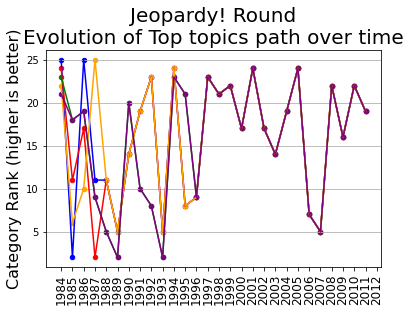

In [346]:
colors = ['blue', 'red', 'green', 'orange', 'purple']

fig, ax = plt.subplots()

for i in range(top_topics):
    pts, x, alphas = gen_points(score_idx, i, max_scores)
    plt.plot(x, pts, '-', color=colors[i])#, alpha=alphas)
    plt.scatter(x, pts, color=colors[i], s=20)

plt.grid(axis='y')
plt.ylabel('Category Rank (higher is better)', fontsize=16)
plt.xticks(ticks=range(yr_cts), labels=[1984+_ for _ in range(yr_cts)], rotation=90, fontsize=12)
plt.title('Jeopardy! Round\nEvolution of Top topics path over time', fontsize=20)
# plt.savefig('jprdy_rd_cats_over_time.png')

# Fix argmax to be mutually exclusive, top topic gets first choice
- so topic 0 gets first choice of next year's topics to match
- topic 1 can pick all that're left, etc

In [324]:
# Argmax to get the next year topic each current year topic matches with best
# convert scores into array of points
max_scores = np.apply_along_axis(np.max, arr=scores, axis=2)

score_idx = np.apply_along_axis(np.argmax, axis=2 ,arr=scores)
score_idx.shape

(28, 25)

In [334]:
z = pd.DataFrame(columns=[*range(25)])
z.head(2)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24


__Added a similarity threshold further down at `if np.max(topic) > 0` line__

In [412]:
'''
scores is shape (year, current_year_topic_idx, jiccard_scores)
Grabbing the argmax for each row - row idx represent topic importance so row0 in year0 is 1984's most impt topic
then zero'ing that index in possible future candidates for this year

So every year, topic 0 gets to pick similarity to next years topics first, etc
'''
yr_scores = []

for yr_idx, yr_values in enumerate(scores):
    yr_scores.append({})
    chosen = []
    for i, topic in enumerate(yr_values):  # row 
        # print(topic)
        topic[chosen] = 0
        if np.max(topic) > 0:  # only take non-zeros
            chosen.append(np.argmax(topic))
            yr_scores[-1][i] = chosen[-1]
            # print(topic)  # check zeroing works right
        else:
            yr_scores[-1][i] = np.nan


In [378]:
np.argmax(scores[0, 0, :])

7

In [382]:
yr_scores[0][0], yr_scores[1][7], yr_scores[2][20], yr_scores[3][8]

(7, 20, 8, 22)

In [407]:
def gen_points2(yr_scores, idx, num_topics=25):
    '''
    # given a list of dicts {current_topic: next_year_topic}
    # chain through the list and return until hitting np.nan
    # sounds an awfully lot like a linked list
    '''
    pts = [idx]
    
    for yr_dict in yr_scores:
        if np.isnan(yr_dict[idx]):
            return np.abs(np.array(pts)-num_topics), [*range(len(pts))]

        pts.append(yr_dict[idx])
        idx = pts[-1]
        
    return np.abs(np.array(pts)-num_topics), [*range(len(pts))]

In [403]:
z[0]

nan

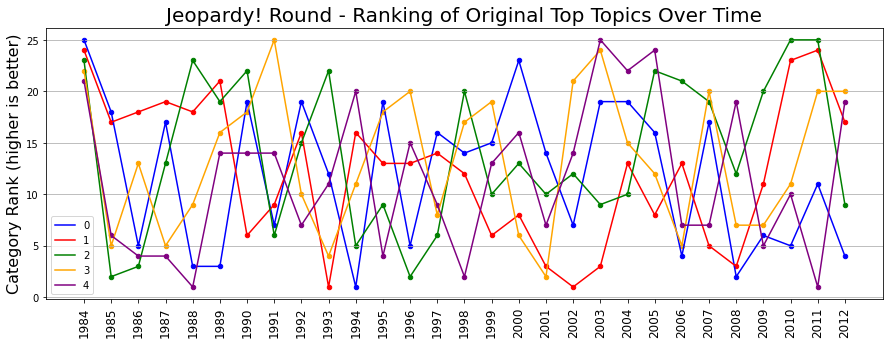

In [413]:
colors = ['blue', 'red', 'green', 'orange', 'purple']

fig, ax = plt.subplots(figsize=(15,5))

for i in range(top_topics):
    pts, x = gen_points2(yr_scores, i)
    plt.plot(x, pts, '-', color=colors[i], label=i)#, alpha=alphas)
    plt.scatter(x, pts, color=colors[i], s=20)

plt.grid(axis='y')
plt.ylabel('Category Rank (higher is better)', fontsize=16)
plt.xticks(ticks=range(yr_cts), labels=[1984+_ for _ in range(yr_cts)], rotation=90, fontsize=12)
plt.title('Jeopardy! Round - Ranking of Original Top Topics Over Time', fontsize=20)
plt.legend()
# plt.savefig('jprdy_rd_cats_over_time.png')

notes:<br>
- Haven't tested the variance of this over time or in comparison to the other rounds
- The topic idx #1 seems to be low most most of the time then shoots back up in the end


## Add Jiccard Threshold
__Should turn this into a function__

In [399]:
'''
scores is shape (year, current_year_topic_idx, jiccard_scores)
Grabbing the argmax for each row - row idx represent topic importance so row0 in year0 is 1984's most impt topic
then zero'ing that index in possible future candidates for this year
'''
threshold = .2
yr_scores = []

for yr_idx, yr_values in enumerate(scores):
    yr_scores.append({})
    chosen = []
    for i, topic in enumerate(yr_values):  # row 
        # print(topic)
        topic[chosen] = 0
        if np.max(topic) > threshold:  # only take normalized Jiccard score > threshold
            chosen.append(np.argmax(topic))
            yr_scores[-1][i] = chosen[-1]
            # print(topic)  # check zeroing works right
        else:
            yr_scores[-1][i] = np.nan


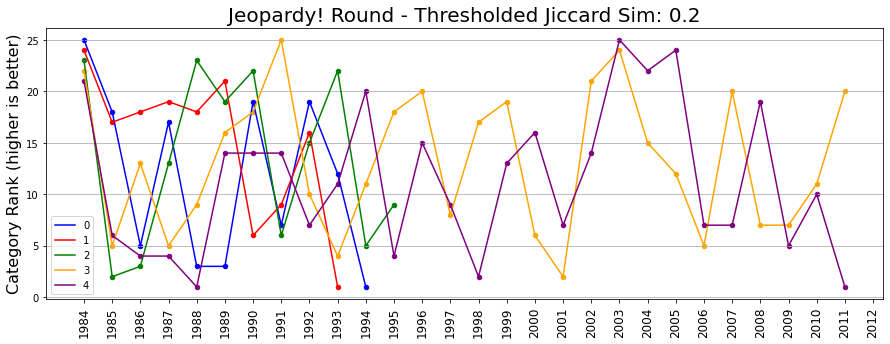

In [411]:
colors = ['blue', 'red', 'green', 'orange', 'purple']

fig, ax = plt.subplots(figsize=(15,5))

for i in range(top_topics):
    pts, x = gen_points2(yr_scores, i)
    plt.plot(x, pts, '-', color=colors[i], label=i)#, alpha=alphas)
    plt.scatter(x, pts, color=colors[i], s=20)

plt.grid(axis='y')
plt.ylabel('Category Rank (higher is better)', fontsize=16)
plt.xticks(ticks=range(yr_cts), labels=[1984+_ for _ in range(yr_cts)], rotation=90, fontsize=12)
plt.title(f'Jeopardy! Round - Thresholded Jiccard Sim: {threshold}', fontsize=20)
plt.legend()
plt.show()
# plt.savefig('jprdy_rd_cats_over_time.png')

Notes - three categories die out in the mid '90s.